In [1]:
utils_path = "../utils"
models_path = "../models"
data_path = "../data/faces_200"

import sys
import os
sys.path.insert(1, utils_path)
sys.path.insert(2, models_path)

import torch 
import torch.nn as nn

import matplotlib.pyplot as plt

import numpy as np

from comet_ml import Experiment

import config

import time 
import copy
from tqdm.notebook import trange, tqdm

import torchvision

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms as transformss

from MBNV3 import MobileNetV3

from functions import train, evaluate, confusion, unzip_files, unzip

In [2]:
#Initialising GereralTorch class

#Setting the experiment with the API key stored in config.py
experiment = Experiment(project_name = "Celebs_MobileNet", workspace = "leothesouthafrican", api_key = config.api_key)

#Report multiple hyperparameters using a dictionary
hyper_params = {
    'learning_rate': 0.001,
    'epochs': 300,
    'batch_size': 32,
    'image_size': 128,
    'image_channels': 3,
    'output_size': len(os.listdir(data_path)) - 1,
    'num_layers': 'na',
    'train_val_split': 0.90,
    'device': 'mps',
    'model_name': 'Basic MobileNetV3',
    'criterion': 'CrossEntropyLoss',
    'optimizer': 'Adam',
    'dataset': 'MSFT-FACES',
    'best_model_path': 'output/MN3L_faces200.pt',
    'loaded_model_path': '/Users/leo/Desktop/Thesis/faces_dataset/output/MN3L_faces200.pt',
    'comet_experiment': experiment,
    'save_at_end': True,
}

print(f'Output Size: {hyper_params["output_size"]}')

#Setting the device
device = torch.device(hyper_params['device'])

#checking if the model is to be a loaded one and if so loading it
if hyper_params['loaded_model_path']:
    state_dict = torch.load(hyper_params['loaded_model_path']) #Loading the state dict
    model = MobileNetV3(mode='large') #Loading the model as a backbone
    model.load_state_dict(state_dict) #Loading the state dict into the model
    print('Model Loaded')
else:
    # Loading a fresh model
    model = MobileNetV3(mode='large')

#passing the model to the device
model.to(device)

# Setting the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device) #Setting the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['learning_rate']) #Setting the optimizer

# Logging the hyperparameters to comet
experiment.log_parameters(hyper_params)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/celebs-mobilenet/de34aac30e734a5e9a060ba2e38af6d7



Output Size: 200
Model Loaded


In [3]:
#defining transforms

train_transform = transforms.Compose([
                transforms.Resize((hyper_params['image_size'],hyper_params['image_size'])),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.1),
                transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.8,1.2)),
                transforms.RandomRotation(15),
                transforms.RandomHorizontalFlip(0.3333),
                transforms.RandomVerticalFlip(0.2),
                transforms.RandomErasing(0.3333),
                transforms.RandomCrop(hyper_params['image_size'], padding=2)
            ])

test_transform = transforms.Compose([
                transforms.Resize((hyper_params['image_size'],hyper_params['image_size'])),
                transforms.ToTensor()
            ])

In [4]:
#Loading the dataset

dataset = datasets.ImageFolder(root=data_path, transform=train_transform)

#Splitting the dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#Creating the dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=8)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=False,
                                            num_workers=8)

# split the dataset into train and validation
train_size = int(hyper_params['train_val_split'] * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Creating the dataloaders
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=False,
                                            num_workers=4)

print('Train data size: ', len(train_dataset))
print('Validation data size: ', len(val_dataset))
print('Test data size: ', len(test_dataset))

Train data size:  12960
Validation data size:  1440
Test data size:  2880


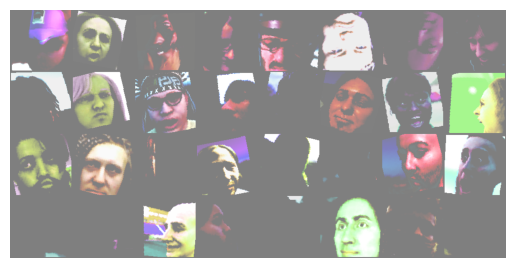

tensor(117) tensor(137) tensor(149) tensor(13)


In [5]:
#display random images from the dataset

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

In [6]:
with experiment.train():
    train(model, criterion, optimizer, hyper_params, train_loader, val_loader)

Begin training...


100%|██████████| 45/45 [00:24<00:00,  1.80it/s]


Model saved on best accuracy!
	Train Loss: 1.705 | Train Acc: 37.50%
Epoch: 02 | Epoch Time: 2m 35s
	 Val. Loss: 2.297 |  Val. Acc: 30.21%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


Model saved on best accuracy!
	Train Loss: 2.569 | Train Acc: 25.00%
Epoch: 03 | Epoch Time: 2m 30s
	 Val. Loss: 2.251 |  Val. Acc: 30.28%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


	Train Loss: 2.610 | Train Acc: 31.25%
Epoch: 04 | Epoch Time: 2m 27s
	 Val. Loss: 2.287 |  Val. Acc: 30.21%


100%|██████████| 45/45 [00:24<00:00,  1.81it/s]


Model saved on best accuracy!
	Train Loss: 3.013 | Train Acc: 28.12%
Epoch: 05 | Epoch Time: 2m 27s
	 Val. Loss: 2.186 |  Val. Acc: 32.29%


100%|██████████| 45/45 [00:24<00:00,  1.81it/s]


Model saved on best accuracy!
	Train Loss: 2.022 | Train Acc: 34.38%
Epoch: 06 | Epoch Time: 2m 29s
	 Val. Loss: 2.139 |  Val. Acc: 32.71%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


Model saved on best accuracy!
	Train Loss: 2.362 | Train Acc: 31.25%
Epoch: 07 | Epoch Time: 2m 27s
	 Val. Loss: 2.099 |  Val. Acc: 33.12%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


Model saved on best accuracy!
	Train Loss: 2.107 | Train Acc: 21.88%
Epoch: 08 | Epoch Time: 2m 26s
	 Val. Loss: 2.107 |  Val. Acc: 33.19%


100%|██████████| 45/45 [00:24<00:00,  1.81it/s]


Model saved on best accuracy!
	Train Loss: 2.363 | Train Acc: 34.38%
Epoch: 09 | Epoch Time: 2m 27s
	 Val. Loss: 2.135 |  Val. Acc: 33.26%


100%|██████████| 45/45 [00:24<00:00,  1.81it/s]


Model saved on best accuracy!
	Train Loss: 1.820 | Train Acc: 40.62%
Epoch: 10 | Epoch Time: 2m 30s
	 Val. Loss: 2.066 |  Val. Acc: 34.17%


100%|██████████| 45/45 [00:24<00:00,  1.80it/s]


	Train Loss: 2.597 | Train Acc: 28.12%
Epoch: 11 | Epoch Time: 2m 28s
	 Val. Loss: 2.092 |  Val. Acc: 33.54%


100%|██████████| 45/45 [00:24<00:00,  1.81it/s]


Model saved on best accuracy!
	Train Loss: 1.847 | Train Acc: 34.38%
Epoch: 12 | Epoch Time: 2m 27s
	 Val. Loss: 1.993 |  Val. Acc: 35.62%


100%|██████████| 45/45 [00:24<00:00,  1.81it/s]


	Train Loss: 1.559 | Train Acc: 43.75%
Epoch: 13 | Epoch Time: 2m 28s
	 Val. Loss: 2.005 |  Val. Acc: 35.21%


100%|██████████| 45/45 [00:24<00:00,  1.80it/s]


Model saved on best accuracy!
	Train Loss: 1.724 | Train Acc: 50.00%
Epoch: 14 | Epoch Time: 2m 28s
	 Val. Loss: 1.993 |  Val. Acc: 36.53%


100%|██████████| 45/45 [00:24<00:00,  1.80it/s]


	Train Loss: 2.515 | Train Acc: 31.25%
Epoch: 15 | Epoch Time: 2m 28s
	 Val. Loss: 1.951 |  Val. Acc: 35.35%


100%|██████████| 45/45 [00:25<00:00,  1.79it/s]


Model saved on best accuracy!
	Train Loss: 2.294 | Train Acc: 34.38%
Epoch: 16 | Epoch Time: 2m 29s
	 Val. Loss: 1.900 |  Val. Acc: 38.12%


100%|██████████| 45/45 [00:24<00:00,  1.80it/s]


	Train Loss: 1.727 | Train Acc: 31.25%
Epoch: 17 | Epoch Time: 2m 29s
	 Val. Loss: 1.931 |  Val. Acc: 36.67%


100%|██████████| 45/45 [00:24<00:00,  1.80it/s]


	Train Loss: 1.417 | Train Acc: 50.00%
Epoch: 18 | Epoch Time: 2m 28s
	 Val. Loss: 1.923 |  Val. Acc: 37.22%


100%|██████████| 45/45 [00:25<00:00,  1.79it/s]


	Train Loss: 2.301 | Train Acc: 37.50%
Epoch: 19 | Epoch Time: 2m 29s
	 Val. Loss: 1.898 |  Val. Acc: 37.92%


100%|██████████| 45/45 [00:24<00:00,  1.81it/s]


	Train Loss: 1.447 | Train Acc: 50.00%
Epoch: 20 | Epoch Time: 2m 29s
	 Val. Loss: 2.015 |  Val. Acc: 34.44%


100%|██████████| 45/45 [00:24<00:00,  1.80it/s]


	Train Loss: 1.188 | Train Acc: 53.12%
Epoch: 21 | Epoch Time: 2m 29s
	 Val. Loss: 1.897 |  Val. Acc: 36.94%


100%|██████████| 45/45 [00:24<00:00,  1.80it/s]


Model saved on best accuracy!
	Train Loss: 2.432 | Train Acc: 31.25%
Epoch: 22 | Epoch Time: 2m 29s
	 Val. Loss: 1.845 |  Val. Acc: 39.38%


100%|██████████| 45/45 [00:25<00:00,  1.80it/s]


	Train Loss: 1.772 | Train Acc: 50.00%
Epoch: 23 | Epoch Time: 2m 29s
	 Val. Loss: 1.910 |  Val. Acc: 38.06%


100%|██████████| 45/45 [00:24<00:00,  1.80it/s]


	Train Loss: 1.489 | Train Acc: 37.50%
Epoch: 24 | Epoch Time: 2m 29s
	 Val. Loss: 1.825 |  Val. Acc: 38.33%


100%|██████████| 45/45 [00:25<00:00,  1.80it/s]


	Train Loss: 1.418 | Train Acc: 56.25%
Epoch: 25 | Epoch Time: 2m 29s
	 Val. Loss: 1.775 |  Val. Acc: 39.38%


100%|██████████| 45/45 [00:24<00:00,  1.80it/s]


Model saved on best accuracy!
	Train Loss: 2.140 | Train Acc: 31.25%
Epoch: 26 | Epoch Time: 2m 29s
	 Val. Loss: 1.750 |  Val. Acc: 40.56%


100%|██████████| 45/45 [00:25<00:00,  1.79it/s]


	Train Loss: 0.966 | Train Acc: 46.88%
Epoch: 27 | Epoch Time: 2m 29s
	 Val. Loss: 1.797 |  Val. Acc: 38.96%


100%|██████████| 45/45 [00:24<00:00,  1.80it/s]


Model saved on best accuracy!
	Train Loss: 1.935 | Train Acc: 28.12%
Epoch: 28 | Epoch Time: 2m 28s
	 Val. Loss: 1.736 |  Val. Acc: 40.97%


100%|██████████| 45/45 [00:24<00:00,  1.80it/s]


	Train Loss: 2.044 | Train Acc: 40.62%
Epoch: 29 | Epoch Time: 2m 29s
	 Val. Loss: 1.793 |  Val. Acc: 38.96%


100%|██████████| 45/45 [00:25<00:00,  1.79it/s]


Model saved on best accuracy!
	Train Loss: 1.935 | Train Acc: 50.00%
Epoch: 30 | Epoch Time: 2m 29s
	 Val. Loss: 1.720 |  Val. Acc: 42.01%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


	Train Loss: 2.032 | Train Acc: 40.62%
Epoch: 31 | Epoch Time: 5m 14s
	 Val. Loss: 1.753 |  Val. Acc: 39.93%


100%|██████████| 45/45 [00:24<00:00,  1.81it/s]


	Train Loss: 1.636 | Train Acc: 43.75%
Epoch: 32 | Epoch Time: 2m 25s
	 Val. Loss: 1.797 |  Val. Acc: 38.61%


100%|██████████| 45/45 [00:24<00:00,  1.81it/s]


	Train Loss: 1.374 | Train Acc: 37.50%
Epoch: 33 | Epoch Time: 2m 25s
	 Val. Loss: 1.748 |  Val. Acc: 40.28%


100%|██████████| 45/45 [00:24<00:00,  1.81it/s]


	Train Loss: 1.901 | Train Acc: 34.38%
Epoch: 34 | Epoch Time: 2m 39s
	 Val. Loss: 1.708 |  Val. Acc: 41.46%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


	Train Loss: 1.446 | Train Acc: 46.88%
Epoch: 35 | Epoch Time: 2m 26s
	 Val. Loss: 1.721 |  Val. Acc: 40.90%


100%|██████████| 45/45 [00:24<00:00,  1.83it/s]


	Train Loss: 1.356 | Train Acc: 53.12%
Epoch: 36 | Epoch Time: 2m 23s
	 Val. Loss: 1.706 |  Val. Acc: 40.83%


100%|██████████| 45/45 [00:25<00:00,  1.80it/s]


Model saved on best accuracy!
	Train Loss: 1.806 | Train Acc: 31.25%
Epoch: 37 | Epoch Time: 2m 28s
	 Val. Loss: 1.647 |  Val. Acc: 43.19%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


	Train Loss: 2.030 | Train Acc: 43.75%
Epoch: 38 | Epoch Time: 2m 26s
	 Val. Loss: 2.041 |  Val. Acc: 34.79%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


	Train Loss: 1.430 | Train Acc: 34.38%
Epoch: 39 | Epoch Time: 2m 23s
	 Val. Loss: 1.763 |  Val. Acc: 40.56%


100%|██████████| 45/45 [00:24<00:00,  1.83it/s]


	Train Loss: 1.773 | Train Acc: 34.38%
Epoch: 40 | Epoch Time: 2m 23s
	 Val. Loss: 1.759 |  Val. Acc: 40.21%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


	Train Loss: 1.189 | Train Acc: 37.50%
Epoch: 41 | Epoch Time: 2m 24s
	 Val. Loss: 1.665 |  Val. Acc: 41.81%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


Model saved on best accuracy!
	Train Loss: 1.385 | Train Acc: 50.00%
Epoch: 42 | Epoch Time: 2m 23s
	 Val. Loss: 1.543 |  Val. Acc: 44.86%


100%|██████████| 45/45 [00:24<00:00,  1.83it/s]


	Train Loss: 1.313 | Train Acc: 46.88%
Epoch: 43 | Epoch Time: 2m 23s
	 Val. Loss: 1.609 |  Val. Acc: 44.10%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


	Train Loss: 1.568 | Train Acc: 34.38%
Epoch: 44 | Epoch Time: 2m 23s
	 Val. Loss: 1.608 |  Val. Acc: 43.12%


100%|██████████| 45/45 [00:24<00:00,  1.83it/s]


	Train Loss: 1.407 | Train Acc: 46.88%
Epoch: 45 | Epoch Time: 2m 23s
	 Val. Loss: 1.689 |  Val. Acc: 42.43%


100%|██████████| 45/45 [00:24<00:00,  1.83it/s]


	Train Loss: 1.832 | Train Acc: 31.25%
Epoch: 46 | Epoch Time: 2m 23s
	 Val. Loss: 1.599 |  Val. Acc: 44.44%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


Model saved on best accuracy!
	Train Loss: 1.607 | Train Acc: 46.88%
Epoch: 47 | Epoch Time: 2m 24s
	 Val. Loss: 1.520 |  Val. Acc: 44.93%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


	Train Loss: 1.476 | Train Acc: 25.00%
Epoch: 48 | Epoch Time: 2m 29s
	 Val. Loss: 1.649 |  Val. Acc: 42.71%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


	Train Loss: 1.764 | Train Acc: 40.62%
Epoch: 49 | Epoch Time: 2m 29s
	 Val. Loss: 1.614 |  Val. Acc: 44.17%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


	Train Loss: 1.733 | Train Acc: 28.12%
Epoch: 50 | Epoch Time: 2m 27s
	 Val. Loss: 1.629 |  Val. Acc: 43.12%


100%|██████████| 45/45 [00:24<00:00,  1.83it/s]


	Train Loss: 1.293 | Train Acc: 34.38%
Epoch: 51 | Epoch Time: 2m 25s
	 Val. Loss: 1.569 |  Val. Acc: 44.93%


100%|██████████| 45/45 [00:24<00:00,  1.83it/s]


	Train Loss: 1.571 | Train Acc: 40.62%
Epoch: 52 | Epoch Time: 2m 24s
	 Val. Loss: 1.574 |  Val. Acc: 44.65%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


Model saved on best accuracy!
	Train Loss: 1.325 | Train Acc: 43.75%
Epoch: 53 | Epoch Time: 2m 24s
	 Val. Loss: 1.551 |  Val. Acc: 45.49%


100%|██████████| 45/45 [00:24<00:00,  1.83it/s]


	Train Loss: 1.990 | Train Acc: 37.50%
Epoch: 54 | Epoch Time: 2m 24s
	 Val. Loss: 1.605 |  Val. Acc: 43.12%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


	Train Loss: 1.496 | Train Acc: 59.38%
Epoch: 55 | Epoch Time: 2m 25s
	 Val. Loss: 1.528 |  Val. Acc: 45.07%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


	Train Loss: 1.662 | Train Acc: 43.75%
Epoch: 56 | Epoch Time: 2m 24s
	 Val. Loss: 1.535 |  Val. Acc: 45.21%


100%|██████████| 45/45 [00:24<00:00,  1.83it/s]


	Train Loss: 1.728 | Train Acc: 28.12%
Epoch: 57 | Epoch Time: 2m 23s
	 Val. Loss: 1.603 |  Val. Acc: 43.82%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


	Train Loss: 1.861 | Train Acc: 37.50%
Epoch: 58 | Epoch Time: 2m 23s
	 Val. Loss: 1.542 |  Val. Acc: 45.28%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


	Train Loss: 1.492 | Train Acc: 43.75%
Epoch: 59 | Epoch Time: 2m 23s
	 Val. Loss: 1.618 |  Val. Acc: 44.31%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


Model saved on best accuracy!
	Train Loss: 1.494 | Train Acc: 46.88%
Epoch: 60 | Epoch Time: 2m 23s
	 Val. Loss: 1.504 |  Val. Acc: 45.76%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


	Train Loss: 1.392 | Train Acc: 43.75%
Epoch: 61 | Epoch Time: 2m 23s
	 Val. Loss: 1.529 |  Val. Acc: 45.00%


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


	Train Loss: 1.366 | Train Acc: 43.75%
Epoch: 62 | Epoch Time: 2m 23s
	 Val. Loss: 1.507 |  Val. Acc: 45.42%


100%|██████████| 45/45 [14:09<00:00, 18.87s/it]


	Train Loss: 0.729 | Train Acc: 46.88%
Epoch: 63 | Epoch Time: 41m 0s
	 Val. Loss: 1.629 |  Val. Acc: 44.58%


100%|██████████| 45/45 [00:25<00:00,  1.79it/s]


	Train Loss: 0.622 | Train Acc: 53.12%
Epoch: 64 | Epoch Time: 8m 23s
	 Val. Loss: 1.579 |  Val. Acc: 45.07%


100%|██████████| 45/45 [00:25<00:00,  1.79it/s]


Model saved on best accuracy!
	Train Loss: 2.029 | Train Acc: 37.50%
Epoch: 65 | Epoch Time: 2m 33s
	 Val. Loss: 1.482 |  Val. Acc: 46.74%


100%|██████████| 45/45 [00:25<00:00,  1.79it/s]


	Train Loss: 1.766 | Train Acc: 50.00%
Epoch: 66 | Epoch Time: 2m 33s
	 Val. Loss: 1.538 |  Val. Acc: 45.21%


100%|██████████| 45/45 [00:25<00:00,  1.78it/s]


	Train Loss: 1.713 | Train Acc: 56.25%
Epoch: 67 | Epoch Time: 2m 33s
	 Val. Loss: 1.508 |  Val. Acc: 46.60%


100%|██████████| 45/45 [00:25<00:00,  1.79it/s]


Model saved on best accuracy!
	Train Loss: 0.621 | Train Acc: 56.25%
Epoch: 68 | Epoch Time: 26m 56s
	 Val. Loss: 1.454 |  Val. Acc: 48.06%


100%|██████████| 45/45 [14:09<00:00, 18.87s/it]


	Train Loss: 0.955 | Train Acc: 50.00%
Epoch: 69 | Epoch Time: 47m 22s
	 Val. Loss: 1.508 |  Val. Acc: 46.53%


100%|██████████| 45/45 [00:25<00:00,  1.79it/s]


	Train Loss: 1.068 | Train Acc: 50.00%
Epoch: 70 | Epoch Time: 43m 47s
	 Val. Loss: 1.544 |  Val. Acc: 45.00%


100%|██████████| 45/45 [00:25<00:00,  1.78it/s]


	Train Loss: 1.023 | Train Acc: 37.50%
Epoch: 71 | Epoch Time: 43m 45s
	 Val. Loss: 1.481 |  Val. Acc: 46.53%


100%|██████████| 45/45 [14:09<00:00, 18.87s/it]


	Train Loss: 1.340 | Train Acc: 53.12%
Epoch: 72 | Epoch Time: 48m 10s
	 Val. Loss: 1.493 |  Val. Acc: 47.57%


 83%|████████▎ | 300/360 [06:47<00:14,  4.17it/s]  

In [ ]:
with experiment.test():

    model.load_state_dict(torch.load(hyper_params['best_model_path']))

    test_loss, test_acc = evaluate(model, test_loader, criterion, device, experiment)

    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

100%|██████████| 90/90 [00:48<00:00,  1.86it/s]

Test Loss: 2.916 | Test Acc: 16.15%


In [ ]:
confusion(model, test_loader, device = device, experiment=experiment)

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/celebs-mobilenet/96ee12350c35402d8750272692024973
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_acc [90]          : (0.2777777777777778, 16.145833333333336)
COMET INFO:     test_loss [90]         : (0.031050565507676868, 2.915825343132019)
COMET INFO:     train_acc [5400]       : (0.0, 0.4375)
COMET INFO:     train_loss [5400]      : (1.44083833694458, 8.327763557434082)
COMET INFO:     train_step_time [5400] : (0, 2)
COMET INFO:     train_val_acc [15]     : (0.0375, 0.2013888888888889)
COMET INFO:     train_val_loss [15]    : (2.696102248297797, 3.904596291648017)
COMET INFO:   Parameters:
COMET INFO:     batch_size        : 32
COMET INFO:     best_model_path   : output/MN3L_faces200.pt
COMET INFO:     comet_e